In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [2]:
import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
import torch
import cv2
import numpy as np
from torch.nn import functional as F
import torch.nn as nn

from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import random

In [3]:
label_datat=np.loadtxt('/home/sumins/workspace/washout classification/min_slice/label_test.txt',dtype=int)
label_datat=label_datat.tolist()
data_patht='/home/sumins/workspace/washout classification/min_slice/channel4_test.nii'
channel4t=[]
totalt=nib.load(data_patht).get_fdata()
totalslicet=totalt.shape[0]  

for i in range(0,totalslicet):
    channel4t.append(totalt[i,:,:,:])

In [4]:
label_data=np.loadtxt('/home/sumins/workspace/washout classification/min_slice/label_train.txt',dtype=int)
label_data=label_data.tolist()
data_path='/home/sumins/workspace/washout classification/min_slice/channel4_train.nii'
channel4=[]
total=nib.load(data_path).get_fdata()
totalslice=total.shape[0]  

for i in range(0,totalslice):
    channel4.append(total[i,:,:,:])


In [5]:
WINDOW_MAX = 200
WINDOW_MIN = 0
GLOBAL_PIXEL_MEAN = 0.1

class CustomDataset(Dataset): 
  def __init__(self,volume_list,all_labels,transforms=None):
    self.volume_list=volume_list
    self.all_labels=all_labels
    self.length=len(all_labels)
    self.transforms=transforms


  def __len__(self):
    return self.length


  def __getitem__(self, idx):
    npy=self.volume_list[idx]

    npy[npy > WINDOW_MAX] = WINDOW_MAX
    npy[npy < WINDOW_MIN] = WINDOW_MIN
    
    npy = (npy - WINDOW_MIN) / (WINDOW_MAX - WINDOW_MIN)
    
    
    npy=npy.astype(dtype='float32')
    if self.transforms is not None:
      npy=self.transforms(npy)
      
    return npy,torch.Tensor([self.all_labels[idx]])

In [15]:

transforms_test = transforms.Compose([transforms.ToTensor()
                                       ])

test_dataset=CustomDataset(volume_list=channel4t, all_labels=label_datat,transforms=transforms_test)

transforms_train = transforms.Compose([transforms.ToTensor()
                                       ])

train_dataset=CustomDataset(volume_list=channel4, all_labels=label_data,transforms=transforms_train)

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, r=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d((1,1))
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels // r),
            nn.ReLU(),
            nn.Linear(in_channels // r, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.squeeze(x)
        x = x.view(x.size(0), -1) 
        x = self.excitation(x)
        x = x.view(x.size(0), x.size(1), 1, 1)
        return x
 
 
class Depthwise(nn.Module):
    def __init__(self, in_num, out_num, stride=1):
        super().__init__()
        
        self.depthwise=nn.Sequential(
            nn.Conv2d(in_num, out_num,3,stride=stride, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.seblock=SEBlock(out_num)
    
    def forward(self,x):
        x=self.depthwise(x)
        x=self.seblock(x)*x
        return x

class CustomConvNet(nn.Module):
    def __init__(self):
        super().__init__() #상속받은 class에 접근하기 위함

        self.layer1 = Depthwise(4, 16) #흑백사진은 inp
        self.layer2 = Depthwise(16, 32)
        self.layer3 = Depthwise(32, 64)
        self.layer4 = Depthwise(64, 128)
        self.layer5 = Depthwise(128, 256)
        self.gap = self.global_avg_pool(256, 2)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.gap(out)
        out = out.view(-1, 2)

        return out


    def global_avg_pool(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1,1)))
        


In [9]:
model=CustomConvNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

checkpoint = torch.load('/home/sumins/workspace/washout classification/model_save/senet_acc.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [10]:
print(model)

CustomConvNet(
  (layer1): Depthwise(
    (depthwise): Sequential(
      (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (seblock): SEBlock(
      (squeeze): AdaptiveAvgPool2d(output_size=(1, 1))
      (excitation): Sequential(
        (0): Linear(in_features=16, out_features=1, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1, out_features=16, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (layer2): Depthwise(
    (depthwise): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [11]:
for i, j in model.named_children():
    print(i)
    print(j)
    print("-"*30)

layer1
Depthwise(
  (depthwise): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (seblock): SEBlock(
    (squeeze): AdaptiveAvgPool2d(output_size=(1, 1))
    (excitation): Sequential(
      (0): Linear(in_features=16, out_features=1, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1, out_features=16, bias=True)
      (3): Sigmoid()
    )
  )
)
------------------------------
layer2
Depthwise(
  (depthwise): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (seblock): SEBlo

In [38]:
class Extractor():
    def __init__(self, model):
        self.model = model
        self.gradients = []
        self.down_result = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def get_gradients(self):
        return self.gradients

    def __call__(self, x):
        self.gradients = []

        x.requires_grad_(True)

        
        for name,module1 in self.model.named_children():
            x=module1(x)
            if name=='layer4':  
                x.register_hook(self.save_gradient)
                target_feature_maps = x
                


        return target_feature_maps, x

class GradCam:
    def __init__(self, model, use_cuda):
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        else:
            self.model = model
        
        self.model.eval()
        self.extractor = Extractor(self.model)

    def __call__(self, input, class_num=1):
        if self.cuda:
            targets, output = self.extractor(input.cuda())
        else:
            targets, output = self.extractor(input)

        label = torch.zeros_like(output, dtype=torch.long)
        label[:, class_num] += 1

        if self.cuda:
            one_hot = torch.sum(label.cuda() * output)
        else:
            one_hot = torch.sum(label * output)
            
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        targets = targets.cpu().data.numpy()[0, :]
        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        
        grad_cam = np.zeros(targets.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            grad_cam += w * targets[i, :, :]

        grad_cam = cv2.resize(grad_cam, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)

        grad_cam = np.maximum(grad_cam, 0)
        cam_max, cam_min = np.max(grad_cam), np.min(grad_cam)
        if cam_max - cam_min > 0:
            grad_cam = (grad_cam - cam_min) / (cam_max - cam_min)
        else:
            grad_cam[:] = 0

        return (grad_cam * 255).astype('uint8')

In [39]:
CAM=GradCam(model,True)

True_label: tensor([0.]), Pred_label: tensor([0], device='cuda:0')


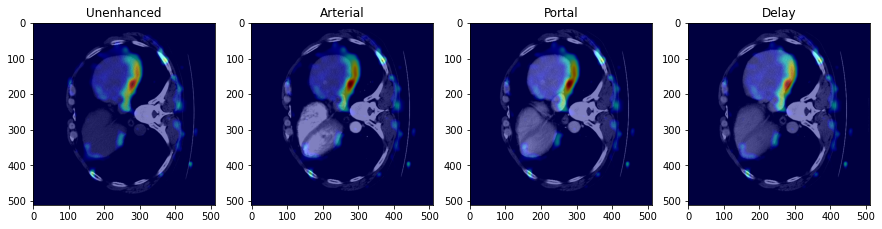

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


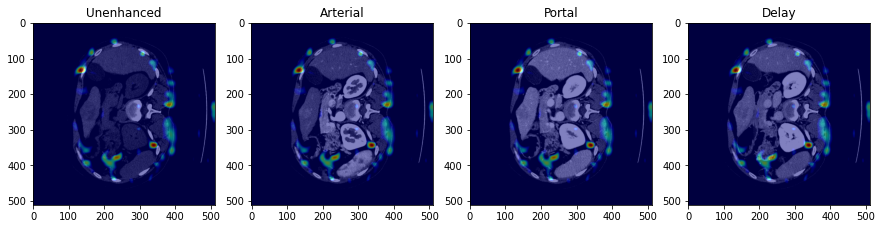

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


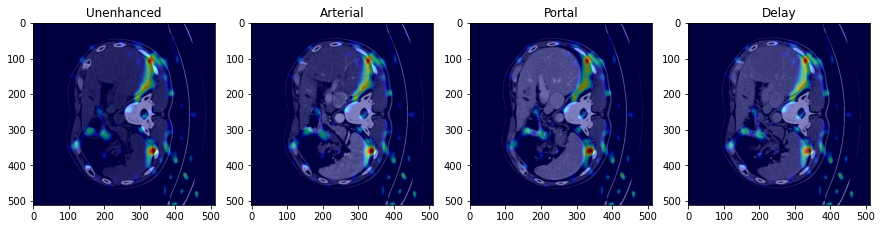

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


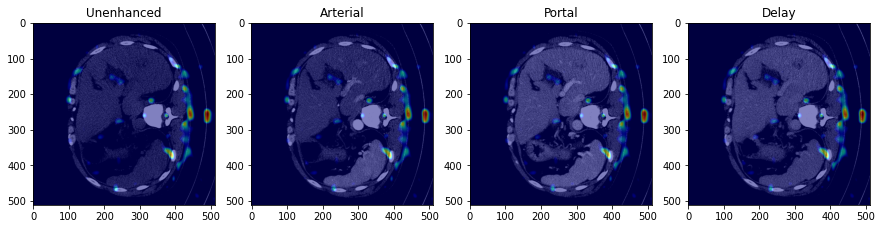

True_label: tensor([0.]), Pred_label: tensor([0], device='cuda:0')


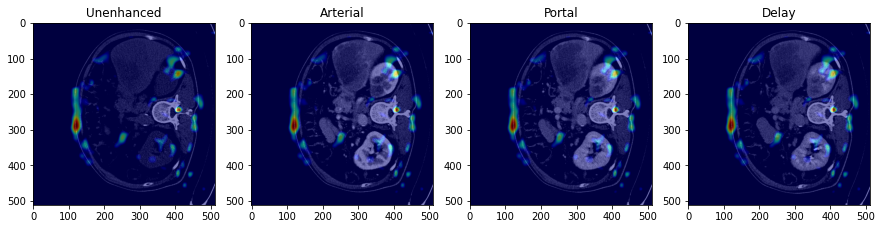

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


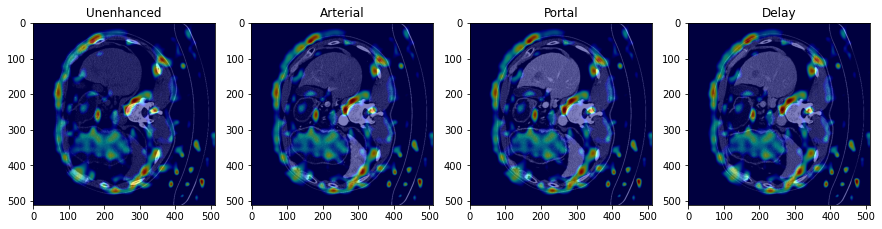

True_label: tensor([0.]), Pred_label: tensor([0], device='cuda:0')


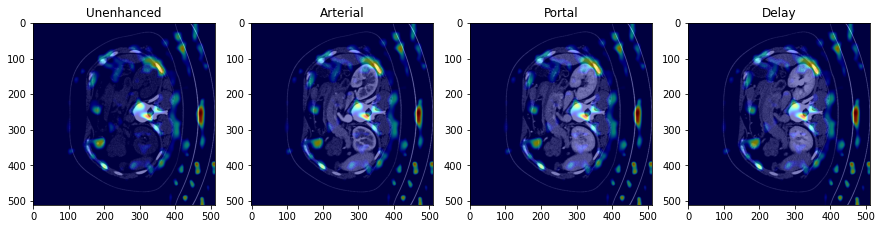

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


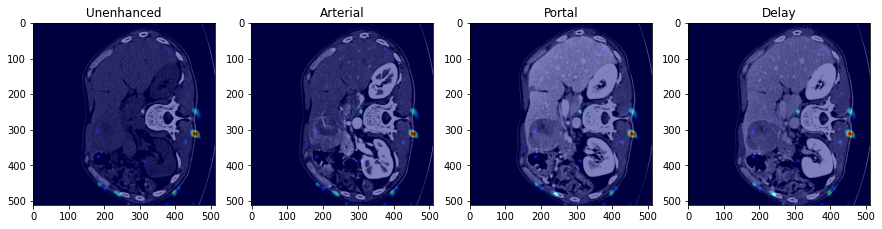

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


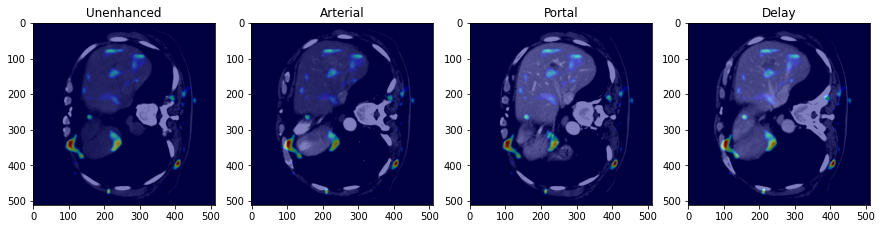

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


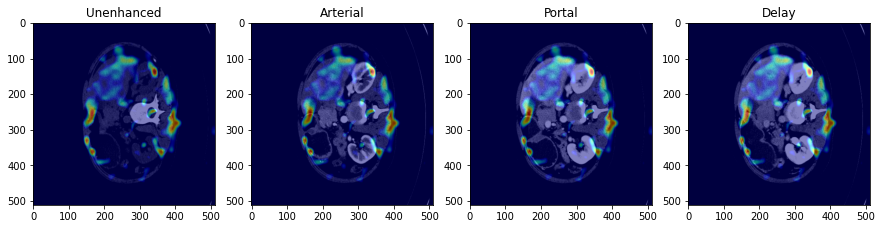

True_label: tensor([1.]), Pred_label: tensor([0], device='cuda:0')


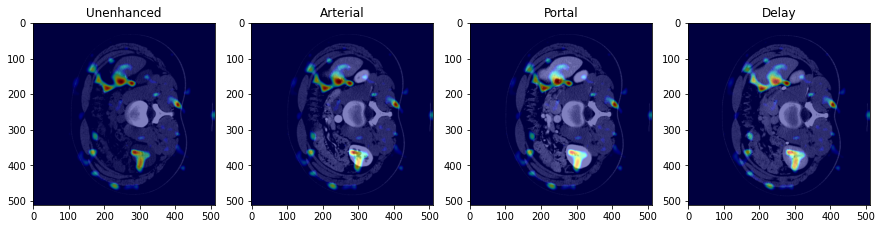

True_label: tensor([0.]), Pred_label: tensor([0], device='cuda:0')


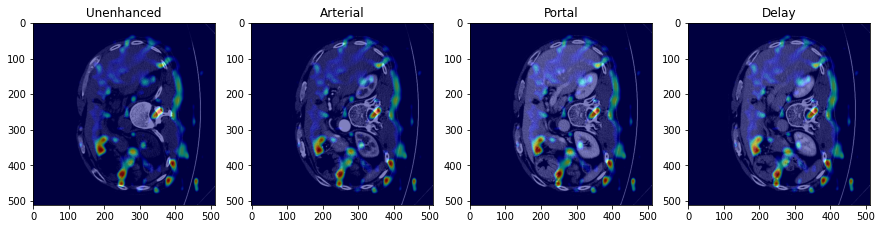

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


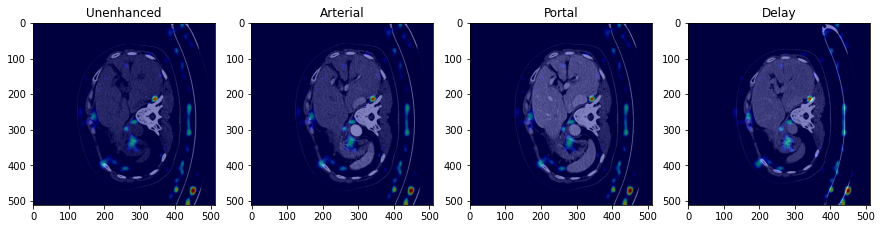

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


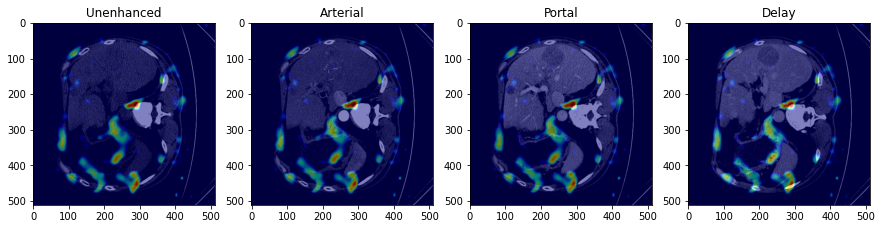

True_label: tensor([0.]), Pred_label: tensor([0], device='cuda:0')


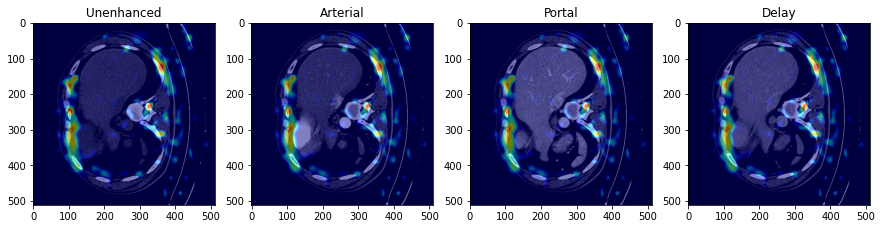

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


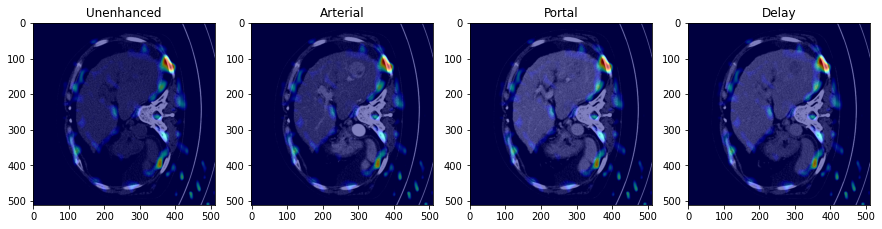

True_label: tensor([0.]), Pred_label: tensor([1], device='cuda:0')


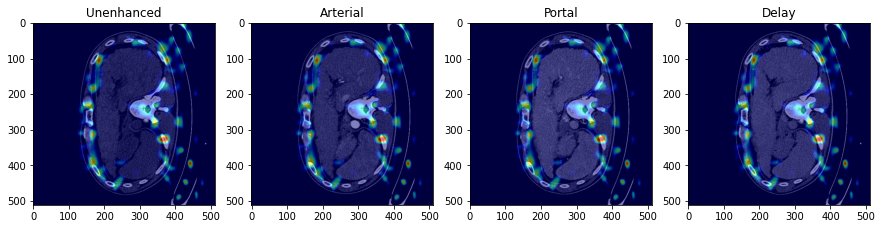

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


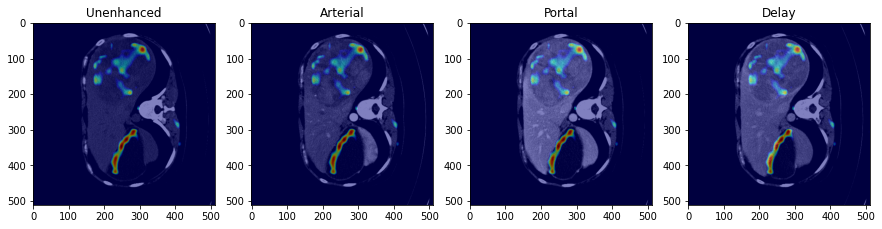

True_label: tensor([0.]), Pred_label: tensor([0], device='cuda:0')


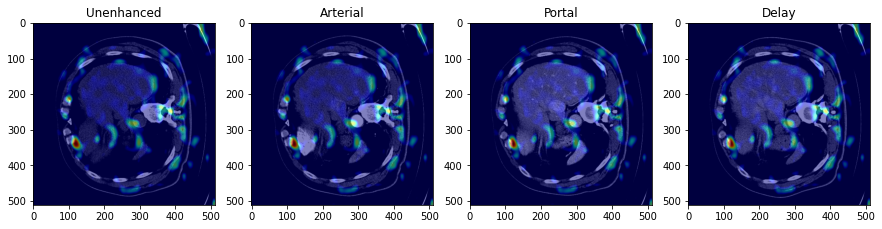

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


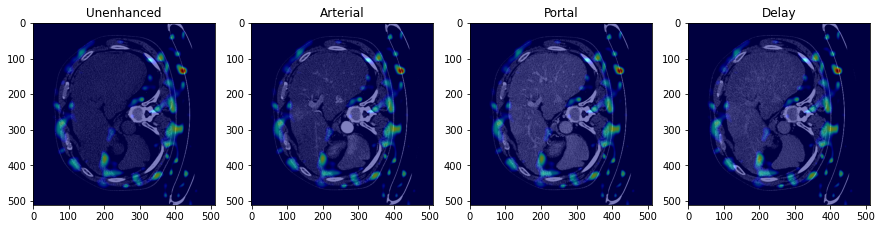

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


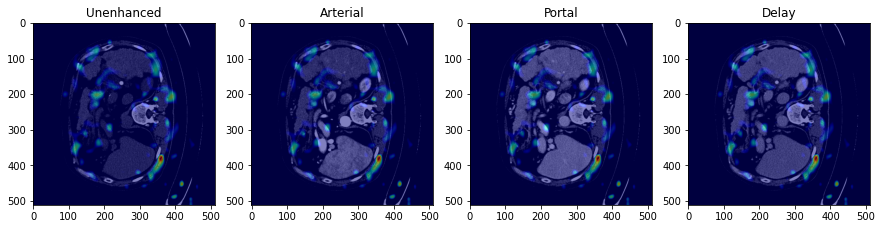

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


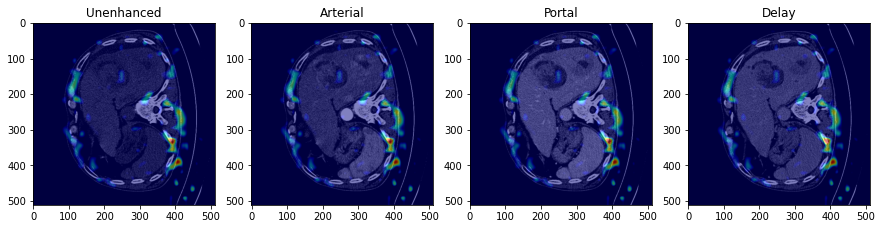

True_label: tensor([1.]), Pred_label: tensor([1], device='cuda:0')


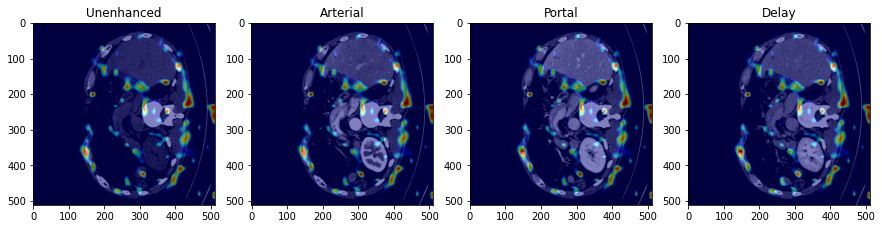

In [40]:
for i in [1,20,40,50 ,102, 150,71, 202,250,300,420,510,560,450,800,1200,1270,333,275,999,840,723,1102]:

    input, label=train_dataset[i]
    out = CAM(torch.unsqueeze(input, 0), 1)
    heatmap = cv2.applyColorMap(out, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    output = model(torch.unsqueeze(input, 0).cuda())
    _, predicted = torch.max(output.data, 1)

    
    #print(output.shape)
    #pred = (F.sigmoid(output)[:, 1, :, :] > 0.5).type(torch.uint8)
    print("True_label: {}, Pred_label: {}".format(label, predicted))
    plt.figure(figsize=(15,15))
    plt.subplot(1,4,1)
    plt.title('Unenhanced')
    plt.imshow(input[1, :, :], cmap='gray')
    plt.imshow(heatmap, alpha=0.5)
    plt.subplot(1,4,2)
    plt.title('Arterial')
    plt.imshow(input[0, :, :], cmap='gray')
    plt.imshow(heatmap, alpha=0.5)
    plt.subplot(1,4,3)
    plt.title('Portal')
    plt.imshow(input[3, :, :], cmap='gray')
    plt.imshow(heatmap, alpha=0.5)
    plt.subplot(1,4,4)
    plt.title('Delay')
    plt.imshow(input[2, :, :], cmap='gray')
    plt.imshow(heatmap, alpha=0.5)
    plt.show()


    # plt.title('Real Mask')
    # plt.imshow(mask, cmap='gray')
    # plt.subplot(2, 3, 6)
    # plt.title('Pred Mask')
    # plt.imshow(pred.cpu()[0], cmap='gray')

In [16]:
for i in range(0,363):

    input, label=test_dataset[i]
    out = CAM(torch.unsqueeze(input, 0), 1)
    heatmap = cv2.applyColorMap(out, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    output = model(torch.unsqueeze(input, 0).cuda())
    _, predicted = torch.max(output.data, 1)
    if predicted.item()==0:
        
        #print(output.shape)
        #pred = (F.sigmoid(output)[:, 1, :, :] > 0.5).type(torch.uint8)
        print("True_label: {}, Pred_label: {}".format(label, predicted))
        plt.figure(figsize=(15,15))
        plt.subplot(1,4,1)
        plt.title('Unenhanced')
        plt.imshow(input[1, :, :], cmap='gray')
        plt.imshow(heatmap, alpha=0.4)
        plt.subplot(1,4,2)
        plt.title('Arterial')
        plt.imshow(input[0, :, :], cmap='gray')
        plt.imshow(heatmap, alpha=0.4)
        plt.subplot(1,4,3)
        plt.title('Portal')
        plt.imshow(input[3, :, :], cmap='gray')
        plt.imshow(heatmap, alpha=0.4)
        plt.subplot(1,4,4)
        plt.title('Delay')
        plt.imshow(input[2, :, :], cmap='gray')
        plt.imshow(heatmap, alpha=0.4)
        plt.show()


    # plt.title('Real Mask')
    # plt.imshow(mask, cmap='gray')
    # plt.subplot(2, 3, 6)
    # plt.title('Pred Mask')
    # plt.imshow(pred.cpu()[0], cmap='gray')

KeyboardInterrupt: 